In [1]:


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import os
import random

import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization,Dense, Flatten
from tensorflow.keras.layers import ELU
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import h5py

from PIL import Image
import io

import gc

In [3]:
path = '/kaggle/input/isic-2024-challenge/'
train_path = path+'train-image/image/'

path_train_meta = path+'train-metadata.csv'
path_test_meta = path+'test-metadata.csv'

test_img_path = path+"test-image.hdf5"

In [4]:
train_data = pd.read_csv(path_train_meta)
train_data.head()

/tmp/ipykernel_23/4196575183.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(path_train_meta)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [5]:
test_data = pd.read_csv(path_test_meta)
test_data.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [6]:
# first row of training data
train_data.iloc[0]

isic_id                                                   ISIC_0015670
target                                                               0
patient_id                                                  IP_1235828
age_approx                                                        60.0
sex                                                               male
anatom_site_general                                    lower extremity
clin_size_long_diam_mm                                            3.04
image_type                                          TBP tile: close-up
tbp_tile_type                                                3D: white
tbp_lv_A                                                     20.244422
tbp_lv_Aext                                                  16.261975
tbp_lv_B                                                     26.922447
tbp_lv_Bext                                                  23.954773
tbp_lv_C                                                     33.684638
tbp_lv

In [7]:
print("The dataset has ", len(train_data), " rows.")
print("The dataset has ", len(train_data.columns), " columns. \n")

The dataset has  401059  rows.
The dataset has  55  columns. 



In [8]:
train_data.dtypes

isic_id                          object
target                            int64
patient_id                       object
age_approx                      float64
sex                              object
anatom_site_general              object
clin_size_long_diam_mm          float64
image_type                       object
tbp_tile_type                    object
tbp_lv_A                        float64
tbp_lv_Aext                     float64
tbp_lv_B                        float64
tbp_lv_Bext                     float64
tbp_lv_C                        float64
tbp_lv_Cext                     float64
tbp_lv_H                        float64
tbp_lv_Hext                     float64
tbp_lv_L                        float64
tbp_lv_Lext                     float64
tbp_lv_areaMM2                  float64
tbp_lv_area_perim_ratio         float64
tbp_lv_color_std_mean           float64
tbp_lv_deltaA                   float64
tbp_lv_deltaB                   float64
tbp_lv_deltaL                   float64


In [9]:
train_data['target'] = train_data['target'].astype(str) 
train_data['isic_id'] = train_data['isic_id']+'.jpg'

In [10]:
train_data['isic_id'][0]

'ISIC_0015670.jpg'

In [11]:
train_data['target'][0]

'0'

In [12]:
#train_data.dtypes

In [13]:
print(train_data.isnull().sum())
print("There are ", train_data.isnull().sum().sum() , "missing values the the dataset.")

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

In [14]:
if train_data['patient_id'].is_unique == False:
    print("The patient ID ist not unique.")
    unique_IDs = train_data['patient_id'].unique()
    print(len(unique_IDs), " unique patient IDs were found out of a total of ", len(train_data), " patients IDs")

The patient ID ist not unique.
1042  unique patient IDs were found out of a total of  401059  patients IDs


In [15]:
if train_data['isic_id'].is_unique == False:
    print("The patient ID ist not unique.")
    unique_IDs = train_data['isic_id'].unique()
    print(len(unique_IDs), " unique isic IDs were found out of a total of ", len(train_data), " isic IDs")
else:
    print("All isic IDs are unique")

All isic IDs are unique


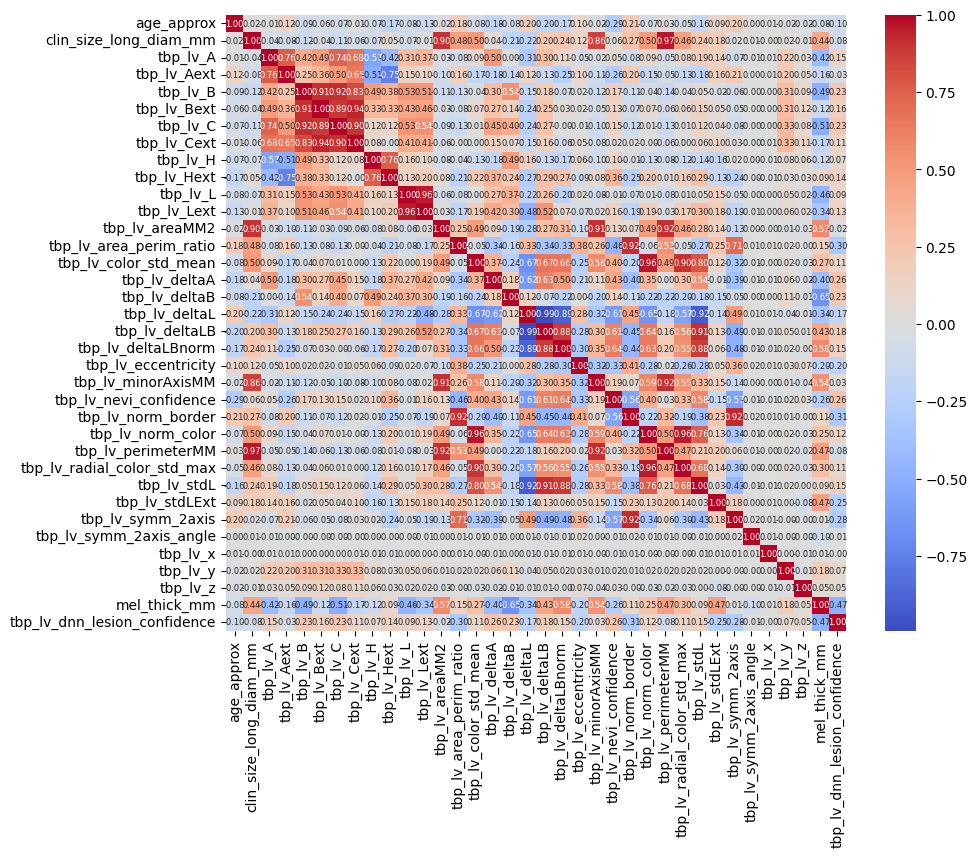

In [16]:
numeric_data = train_data.select_dtypes(include=['number'])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size":6})
plt.show()

target
0    400666
1       393
Name: count, dtype: int64


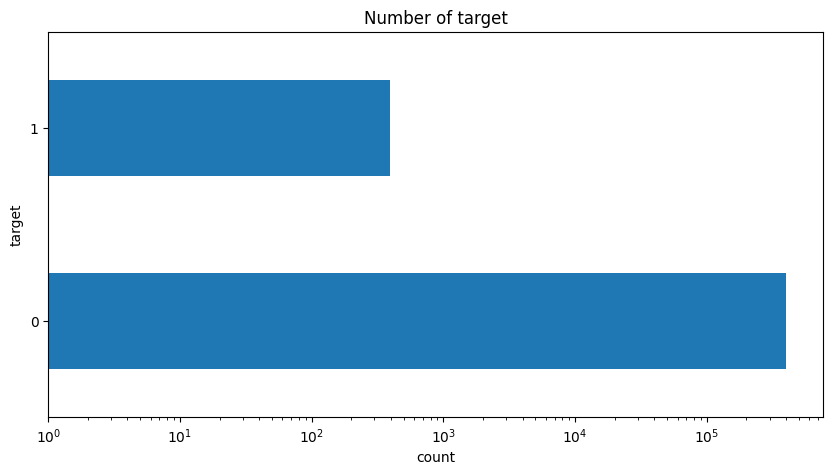

In [17]:
print(train_data['target'].value_counts())

train_data['target'].value_counts().plot.barh(figsize=(10,5), title= "Number of target", xlabel="count", ylabel="target", log=True)
plt.show()

In [18]:
target_1 = train_data[train_data['target']=='1']
multiple_target_1 = target_1.groupby('patient_id').filter(lambda x: len(x) > 1)
unique_patient_ids_target_1 = multiple_target_1['patient_id'].nunique()
print(unique_patient_ids_target_1)

66


In [19]:
multiple_target_1

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
935,ISIC_0096034.jpg,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
1245,ISIC_0104229.jpg,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
1846,ISIC_0119495.jpg,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
3478,ISIC_0157834.jpg,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846
4812,ISIC_0190307.jpg,1,IP_4890448,65.0,male,head/neck,6.10,TBP tile: close-up,3D: XP,36.467641,...,IL_3603982,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,95.272583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388710,ISIC_9690994.jpg,1,IP_8313778,50.0,male,posterior torso,7.26,TBP tile: close-up,3D: white,21.225560,...,IL_2262731,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Superficial spreading",NaN,<1/mm^2,0.4,99.999930
393359,ISIC_9805656.jpg,1,IP_4549819,70.0,male,anterior torso,6.85,TBP tile: close-up,3D: white,21.723512,...,IL_9435969,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Associated with a nevus",NaN,<1/mm^2,0.4,94.403762
396165,ISIC_9877311.jpg,1,IP_4717387,50.0,female,posterior torso,8.16,TBP tile: close-up,3D: XP,17.351658,...,IL_8242602,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,NaN,NaN,NaN,NaN,99.197656
399936,ISIC_9972649.jpg,1,IP_9181133,60.0,male,lower extremity,8.51,TBP tile: close-up,3D: white,19.003400,...,IL_7739568,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,86.048290


In [20]:
# remove all duplicates of patient-ids with target=0
#train_data_unique = train_data.drop_duplicates(subset='patient_id', keep='first')
#print("DataFrame with unique patient-ids: ", len(train_data_unique))

target_0_df = train_data[train_data['target']=='0']
unique_target_0_df = target_0_df.drop_duplicates(subset='patient_id',keep='first')
other_targets_df = train_data[train_data['target']!='0']
train_result = pd.concat([unique_target_0_df, other_targets_df], ignore_index=True)
print(len(train_result))

1434


target
0    1041
1     393
Name: count, dtype: int64


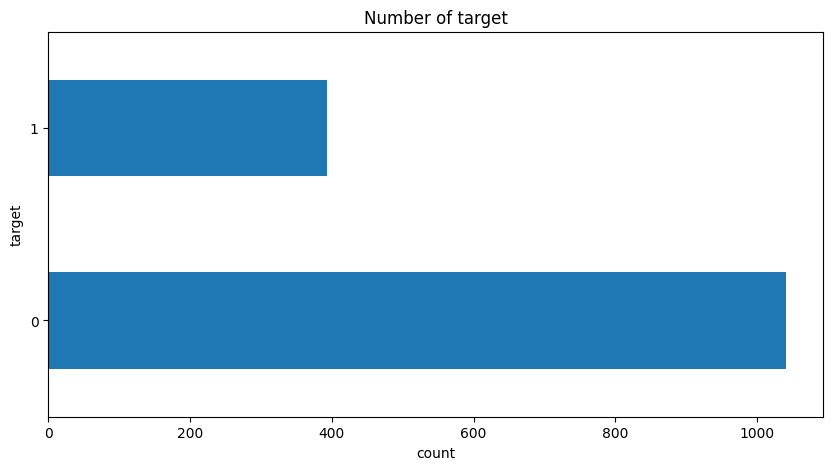

In [21]:
print(train_result['target'].value_counts())

train_result['target'].value_counts().plot.barh(figsize=(10,5), title= "Number of target", xlabel="count", ylabel="target")
plt.show()

In [22]:
train_data = train_result

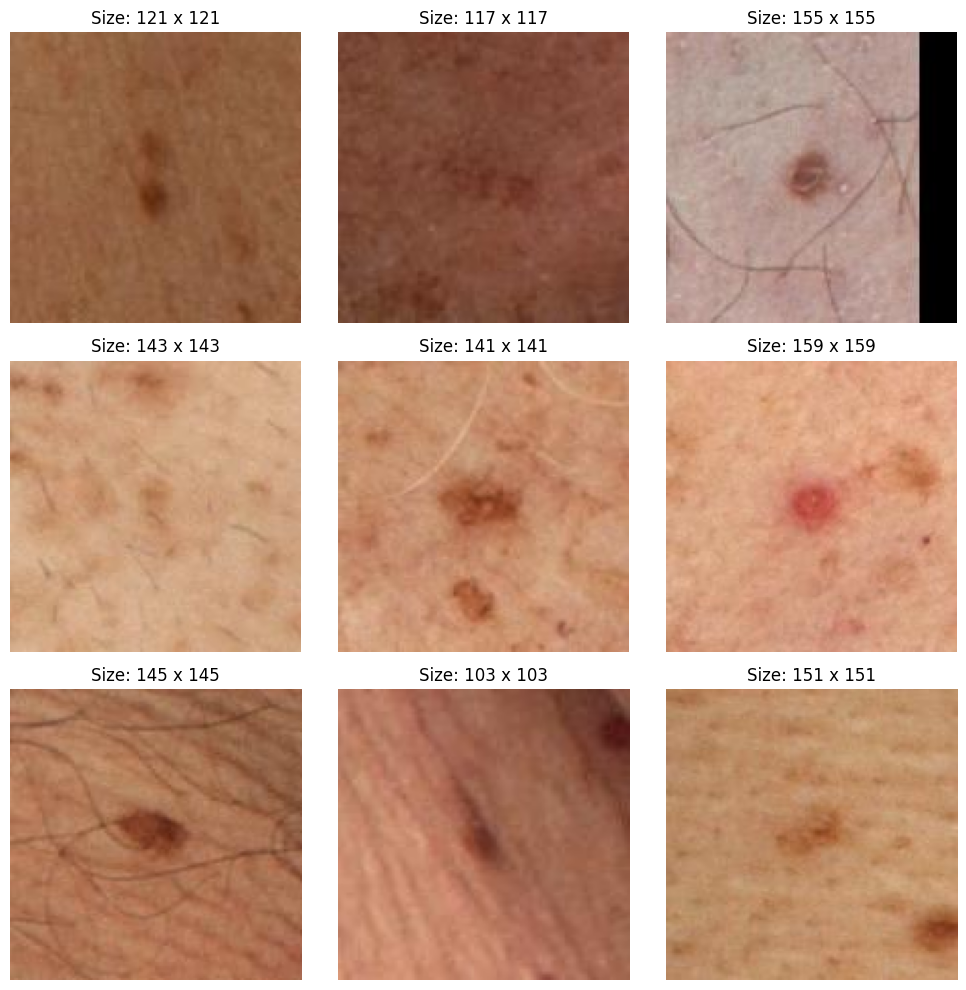

In [23]:
list_images = [f for f in os.listdir(train_path) if f.lower().endswith('.jpg')]

select_images = random.sample(list_images, 9)

images = []
sizes = []
for img in select_images:
    image = cv2.cvtColor(cv2.imread(os.path.join(train_path, img)), cv2.COLOR_BGR2RGB)
    images.append(image)
    sizes.append(image.shape[0:2])

fix, axes = plt.subplots(3, 3, figsize=(10,10))
for ax, img, size in zip(axes.flatten(), images, sizes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Size: {size[0]} x {size[1]}')

plt.tight_layout()
plt.show()

In [24]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), input_shape=(120,120,3)))
    model.add(BatchNormalization())
    model.add(ELU())    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.2))
    
    model.add(Conv2D(32, kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ELU())   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.2))
    
    model.add(Conv2D(64, kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ELU())    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.2))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])
    
    return model    

In [25]:
def plot_training_progress(hist):
    acc = hist.history['accuracy']
    acc_val = hist.history['val_accuracy']
    loss = hist.history['loss']
    loss_val = hist.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label='training_accuracy')
    plt.plot(epochs, acc_val, 'r', label='validation accuracy')
    plt.title('learning curves')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='training loss')
    plt.plot(epochs, loss_val, 'r', label='validation loss')
    plt.title('training and validation loss')
    plt.legend()
    plt.show()

In [26]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify = train_data['target'])

In [27]:
print(len(train_data))
print(len(val_data))

1147
287


In [28]:
train_dir = train_path

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=False, featurewise_std_normalization=False,
                                  horizontal_flip = True, vertical_flip = True, 
                                  zoom_range=0.2, brightness_range=[0.9,1.1],
                                  rotation_range=270)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = train_path

In [30]:
print(train_data['target'].unique())
print(train_data['target'].dtype)


['0' '1']
object


In [31]:
train_generator = train_datagen.flow_from_dataframe(train_data, directory = train_dir,
                                                   x_col='isic_id', y_col='target',
                                                   target_size=(120,120),
                                                   class_mode = 'binary',
                                                   interpolation='nearest',
                                                   shuffle=True,
                                                   batch_size=16)

Found 1147 validated image filenames belonging to 2 classes.


In [32]:
validation_generator = test_datagen.flow_from_dataframe(val_data, directory = train_dir,
                                                   x_col='isic_id', y_col='target',
                                                   target_size=(120,120),
                                                   class_mode = 'sparse',
                                                   interpolation='nearest',
                                                   shuffle=True,
                                                   batch_size=16)

Found 287 validated image filenames belonging to 2 classes.


In [33]:
model = create_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 118, 118, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 118, 118, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 59, 59, 16)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 57, 57, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 57, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 28, 28, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 13, 13, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,794,465 (10.66 MB)

 Trainable params: 2,793,729 (10.66 MB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/45


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724569619.859756      69 service.cc:145] XLA service 0x79ad2c006e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724569619.859824      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/71 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4861 - loss: 1.3883  

I0000 00:00:1724569628.976035      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.6454 - loss: 0.9665 - val_accuracy: 0.7169 - val_loss: 0.6568
Epoch 2/45
 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6875 - loss: 0.5630

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6875 - loss: 0.5630 - val_accuracy: 0.8667 - val_loss: 0.4030
Epoch 3/45
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.7444 - loss: 0.5897 - val_accuracy: 0.7243 - val_loss: 0.6389
Epoch 4/45
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.9375 - loss: 0.3181 - val_accuracy: 0.7333 - val_loss: 0.6237
Epoch 5/45
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7734 - loss: 0.5095 - val_accuracy: 0.7169 - val_loss: 0.7268
Epoch 6/45
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.8750 - loss: 0.2596 - val_accuracy: 0.8667 - val_loss: 0.3281
Epoch 7/45
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7899 - loss: 0.4883 - val_accuracy: 0.7243 - val_loss: 0.5404
Epoch 8/45
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.8750 - loss: 0.3924 - val_accuracy: 0.8000 - val_loss: 0.4794
Epoch 9/45
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.8101 - loss: 0.4782 - val_accuracy: 0.7390 - val_loss: 

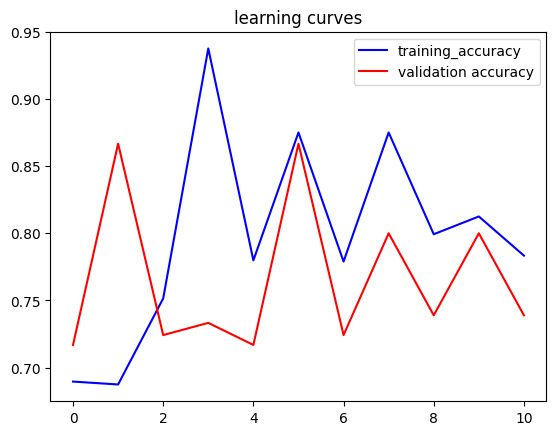

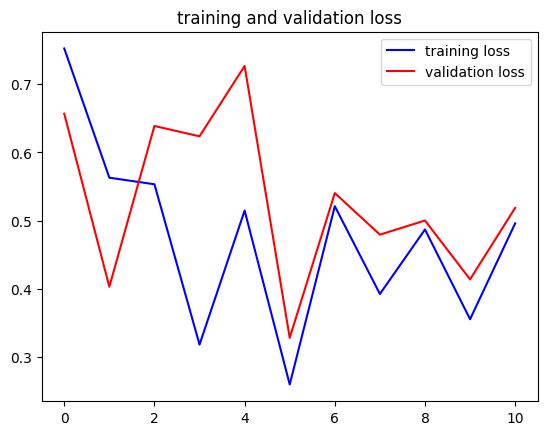

In [34]:
es = EarlyStopping(monitor='val_loss', patience = 5, mode ='min', restore_best_weights=True)

history = model.fit(train_generator,
                   validation_data=validation_generator,
                   epochs=45, verbose=1,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_steps=validation_generator.n//validation_generator.batch_size,
                   callbacks=[es])

plot_training_progress(history)

In [35]:
#image = cv2.cvtColor(cv2.imread('/kaggle/input/isic-2024-challenge/train-image/image/ISIC_0015670.jpg'), cv2.COLOR_BGR2RGB)
#plt.imshow(image)

In [36]:
#img_resized = cv2.resize(image, (120,120))

In [37]:
#img_normalized = img_resized.astype(np.float32) / 255.0

In [38]:
#img_batch = np.expand_dims(img_normalized, axis=0)

In [39]:
#test_pred = model.predict(img_batch)

In [40]:
#test_pred

In [41]:
import h5py
import numpy as np
import cv2

def preprocess_image(img, target_size=(120, 120)):
    # Resize the image
    img_resized = cv2.resize(img, target_size)
    
    # Normalize pixel values to [0, 1]
    img_normalized = img_resized.astype(np.float32) / 255.0
    
    return img_normalized

# Load and preprocess images from HDF5 file
def load_and_preprocess_images(hdf5_file_path):
    with h5py.File(hdf5_file_path, 'r') as hf:
        preprocessed_images = []
        for key in hf.keys():
            img_data = hf[key][()]
            decoded_img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
            preprocessed_img = preprocess_image(decoded_img)
            preprocessed_images.append(preprocessed_img)
            gc.collect()
    
    return np.array(preprocessed_images)

# Use this function to load and preprocess your test images
#test_img_path = 'path/to/your/hdf5_file.h5'
test_images = load_and_preprocess_images(test_img_path)
gc.collect()

# Now you can use these preprocessed images for prediction
##predictions = model.predict(test_images)

0

In [42]:
predictions = model.predict(test_images)
gc.collect()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


349

In [43]:
predictions

array([[0.0757294 ],
       [0.02790324],
       [0.04807128]], dtype=float32)

In [44]:
pred = predictions.flatten()

In [45]:
results = pd.DataFrame({'isic_id': test_data['isic_id'],
                        'target':pred})
gc.collect()

0

In [46]:
results.to_csv('submission.csv', index=False)

In [47]:
results

,isic_id,target
0,ISIC_0015657,0.075729
1,ISIC_0015729,0.027903
2,ISIC_0015740,0.048071


In [48]:
#results.to_csv('/kaggle/working/submission.csv', index=False)